# Ensembles of Models

## 1. Bagging

### Loading Dataset

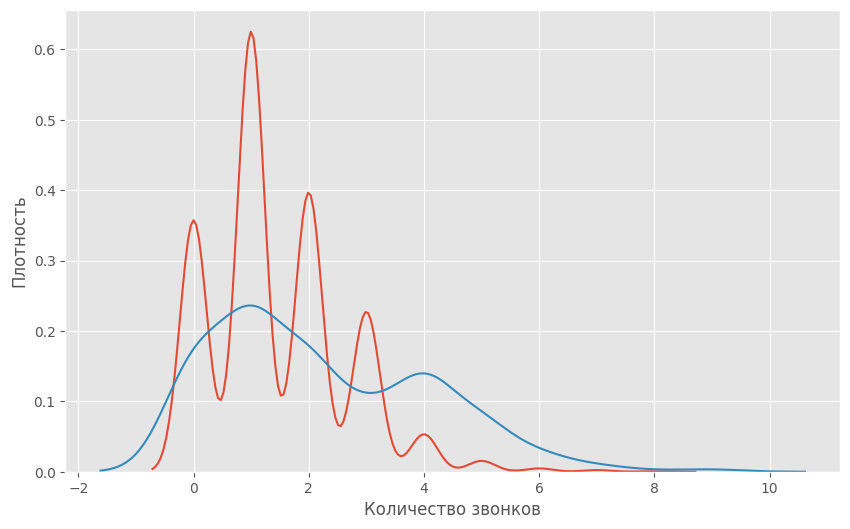

In [4]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6

URL = 'https://drive.google.com/uc?id=1U9LC5ECI2_Jvq4FrZNCOn3gCT7T5Y5DD'
telecom_data = pd.read_csv(URL)

fig = sns.kdeplot(telecom_data[telecom_data['Churn'] == False]['Customer service calls'], label='Loyal')
fig = sns.kdeplot(telecom_data[telecom_data['Churn'] == True]['Customer service calls'], label='Churn')

fig.set(xlabel='Количество звонков', ylabel='Плотность')
plt.show()

### Data Sampling

In [7]:
import numpy as np


def get_bootstrap_samples(data, n_samples, n_data):
    indices = np.random.randint(0, len(data), (n_samples, n_data))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries


n_samples = 3000
n_data = 600

loyal_calls = telecom_data[telecom_data['Churn'] == False]['Customer service calls'].values
churn_calls = telecom_data[telecom_data['Churn'] == True]['Customer service calls'].values

np.random.seed(0)

loyal_mean_scores = [np.mean(sample) for sample in get_bootstrap_samples(loyal_calls, n_samples, n_data)]
churn_mean_scores = [np.mean(sample) for sample in get_bootstrap_samples(churn_calls, n_samples, n_data)]

print('Service calls from loyal: mean interval', stat_intervals(loyal_mean_scores, .05))
print('Service calls from churns: mean interval', stat_intervals(churn_mean_scores, .05))

print('Service calls from loyal: mean', np.mean(loyal_calls))
print('Service calls from churns: mean', np.mean(churn_calls))

Service calls from loyal: mean interval [1.356625   1.54833333]
Service calls from churns: mean interval [2.08495833 2.38666667]
Service calls from loyal: mean 1.4498245614035088
Service calls from churns: mean 2.229813664596273


### Fitting

<>:78: SyntaxWarning: invalid escape sequence '\^'
<>:78: SyntaxWarning: invalid escape sequence '\^'
C:\Users\Иван\AppData\Local\Temp\ipykernel_14920\1060330450.py:78: SyntaxWarning: invalid escape sequence '\^'
  plt.plot(X_test, y_predict[:, i], 'r', alpha=0.1, label='$\^y(x)$')


Tree         : 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)
Bagging (Tree): 0.0196 (error) = 0.0004 (bias^2)  + 0.0092 (var) + 0.0098 (noise)


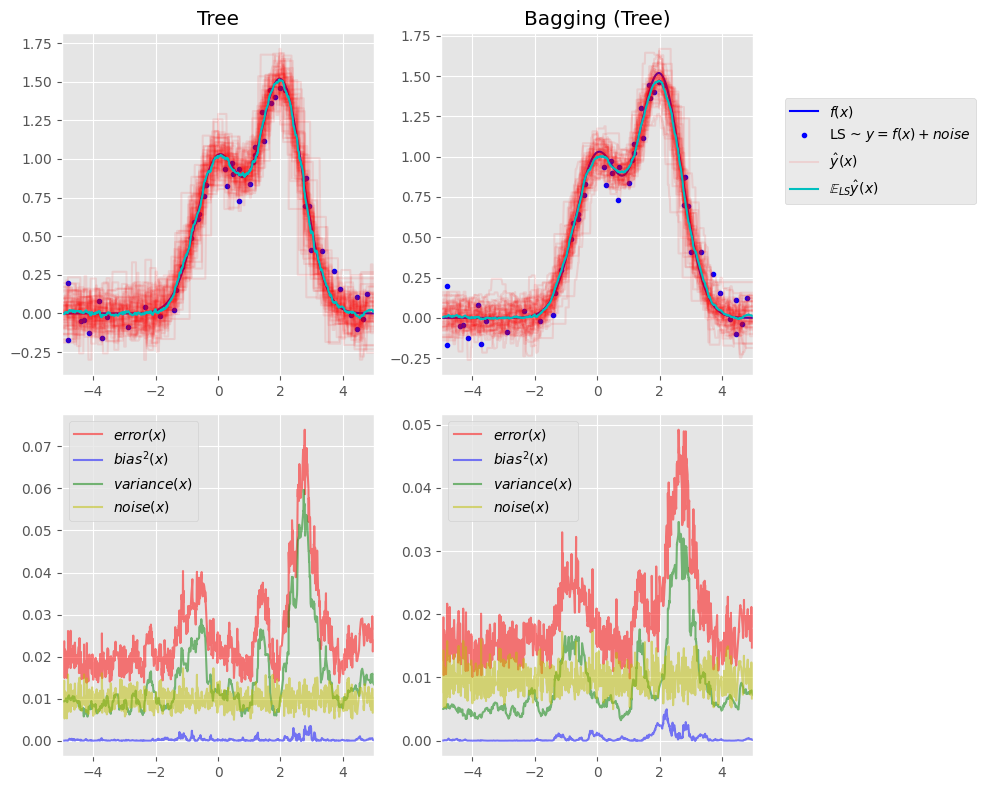

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

n_repeat = 50
n_train = 50
n_test = 1000
noise = .1
np.random.seed(0)

estimators = [('Tree', DecisionTreeRegressor()),
              ('Bagging (Tree)', BaggingRegressor(DecisionTreeRegressor(), n_estimators=10, max_samples=1.0))]
n_estimators = len(estimators)


def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y

X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

plt.figure(figsize=(10, 8))

for n, (name, estimator) in enumerate(estimators):
    y_predict = np.zeros((n_test, n_repeat))
    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)
    
    y_error = np.zeros(n_test)

    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)
    y_noise = np.var(y_test, axis=1)
    y_bias = (f(X_test).ravel() - np.mean(y_predict, axis=1)) ** 2
    y_var = np.var(y_predict, axis=1)

    print('{0:13}: {1:.4f} (error) = {2:.4f} (bias^2) '
          ' + {3:.4f} (var) + {4:.4f} (noise)'.format(name, np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))
    
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), 'b', label='$f(x)$')
    plt.plot(X_train[0], y_train[0], '.b', label='LS ~ $y = f(x) + noise$')

    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], 'r', alpha=0.1, label='$\^y(x)$')
        else:
            plt.plot(X_test, y_predict[:, i], 'r', alpha=0.1)

    plt.plot(X_test, np.mean(y_predict, axis=1), 'c', label=r'$\mathbb{E}_{LS} \^y(x)$')
    plt.xlim([-5, 5])
    plt.title(name)

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, 'r', label='$error(x)$', alpha=0.5)
    plt.plot(X_test, y_bias, 'b', label='$bias^2(x)$', alpha=0.5)
    plt.plot(X_test, y_var, 'g', label='$variance(x)$', alpha=0.5)
    plt.plot(X_test, y_noise, 'y', label='$noise(x)$', alpha=0.5)
    plt.xlim([-5, 5])
    plt.legend()

plt.tight_layout()
plt.show()

## 2. Stacking

### Dataset Generation and Fitting

In [24]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

def Div_plate(clf, flip_level):
    X, y = make_classification(n_samples=10000,
                               n_features=2,
                               n_informative=1,
                               n_redundant=0,
                               n_repeated=0,
                               n_classes=2,
                               n_clusters_per_class=1,
                               class_sep=1,
                               flip_y=flip_level,
                               weights=[.4, .6],
                               random_state=17)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)
    plt.subplots();
    ax1 = plt.gca();
    sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=y_train, ax=ax1);
    sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_test, ax=ax1, marker='+');
    ax1.set_title('Data with noise');
    plt.show()

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    print('Score =', score)
    ind = y_test == y_pred
    plt.subplots();
    ax2 = plt.gca();
    sns.scatterplot(x=X_test[ind, 0], y=X_test[ind, 1], hue=y_test[ind], ax=ax2);
    sns.scatterplot(x=X_test[~ind, 0], y=X_test[~ind, 1], hue=y_pred[~ind], ax=ax2, marker='+');
    ax2.set_title('With Noise');
    plot_step = .01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, levels=1, collors=['blue', 'orange'], aplha=.3)
    plt.show()

### Setting up Models

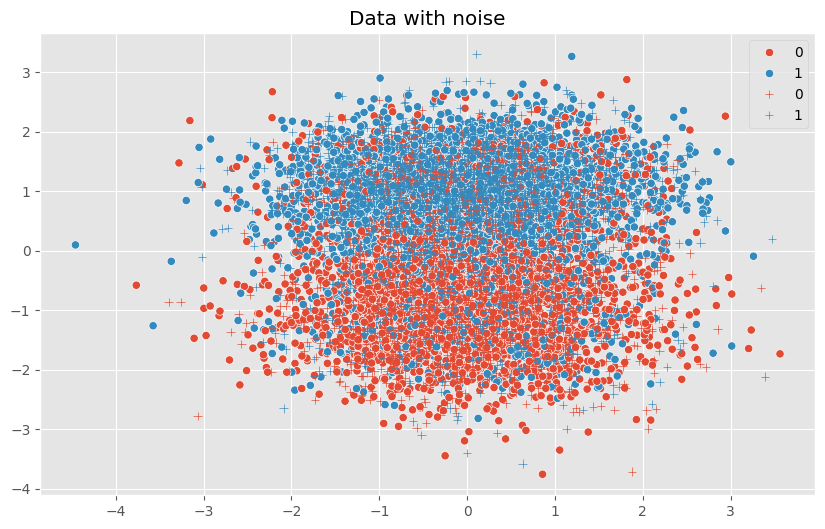

c:\Users\Иван\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Иван\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Иван\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Иван\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Иван\Ap

Score = 0.7627272727272727


C:\Users\Иван\AppData\Local\Temp\ipykernel_14920\2769120624.py:42: UserWarning: The following kwargs were not used by contour: 'collors', 'aplha'
  cs = plt.contourf(xx, yy, Z, levels=1, collors=['blue', 'orange'], aplha=.3)


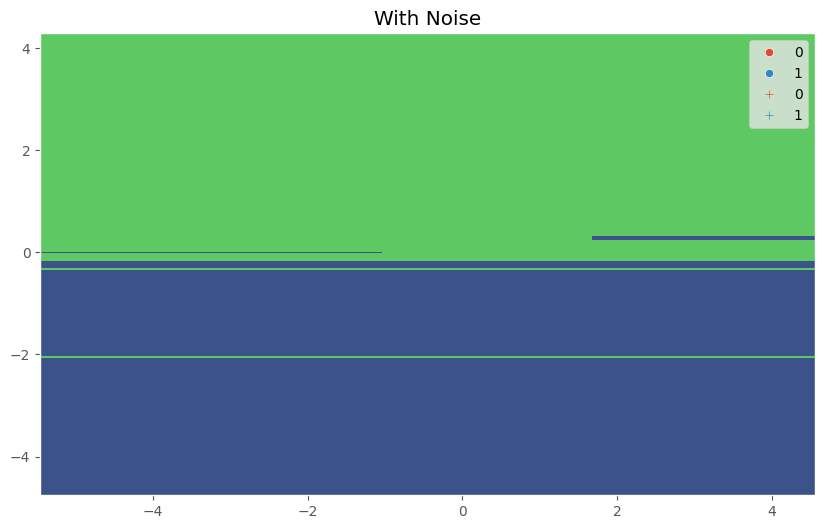

In [25]:
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


estimators = [('SVC', SVC(max_iter=10)),
              ('LogReg', LogisticRegression()),
              ('Tree', DecisionTreeClassifier(max_depth=5))]
clf = StackingClassifier(estimators=estimators)
flip_level = .4
Div_plate(clf, flip_level)

In [18]:
clf.final_estimator_.coef_

array([[-0.62198472,  2.49377763,  2.10981249]])

## 3. Boosting

### Adaboost

In [2]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics


iris = datasets.load_iris()

X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

abc = AdaBoostClassifier(n_estimators=50, learning_rate=1)
model = abc.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Accuracy:', metrics.accuracy_score(y_pred, y_test))

Accuracy: 0.9555555555555556


In [24]:
from sklearn.svm import SVC


svc = SVC(probability=True, kernel='linear') # or 'rbf', 'poly'
abc = AdaBoostClassifier(estimator=svc, n_estimators=50, learning_rate=1)

model = abc.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Accuracy:', metrics.accuracy_score(y_pred, y_test))

Accuracy: 0.9111111111111111


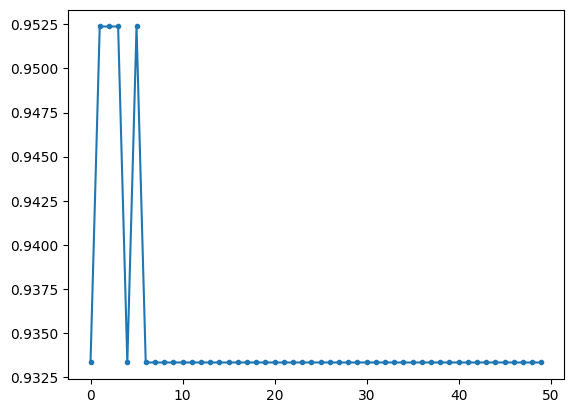

In [25]:
from matplotlib import pyplot as plt


learning_rate = .1
abc = AdaBoostClassifier(estimator=svc, n_estimators=50, learning_rate=learning_rate)
model = abc.fit(X_train, y_train)
score = [s for s in abc.staged_score(X_train, y_train)]
plt.plot(score, marker='.')

In [31]:
from sklearn.datasets import make_classification
import numpy as np
import seaborn as sns


def Div_plate(clf, flip_level):
    X, y = make_classification(n_samples=10000,
                               n_features=2,
                               n_informative=2,
                               n_redundant=0,
                               n_repeated=0,
                               n_classes=2,
                               n_clusters_per_class=1,
                               class_sep=2,
                               flip_y=flip_level,
                               weights=[.5, .5],
                               random_state=17)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

    plt.subplots()
    ax1 = plt.gca()
    sns.scatterplot(x=X_train[:, 0], y=X_train[:, 1], hue=y_train, ax=ax1)
    sns.scatterplot(x=X_test[:, 0], y=X_test[:, 1], hue=y_test, ax=ax1, marker='+')
    ax1.set_title('Data with Noise')
    plt.show()

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = clf.score(X_test, y_test)
    print('Score =', score)

    ind = y_test == y_pred
    plt.subplots()
    ax2 = plt.gca()
    sns.scatterplot(x=X_test[ind, 0], y=X_test[ind, 1], hue=y_test[ind], ax=ax2)
    sns.scatterplot(x=X_test[~ind, 0], y=X_test[~ind, 1], hue=y_pred[~ind], ax=ax2, marker='+')
    ax2.set_title('With Noise')
    plot_step = .01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, levels=1, colors=['blue', 'orange'], alpha=.3)
    plt.show()


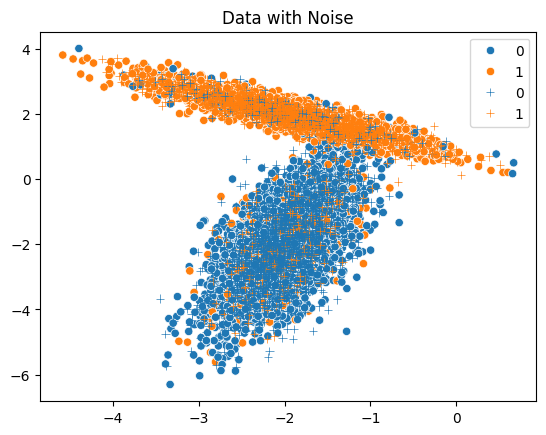

Score = 0.8918181818181818


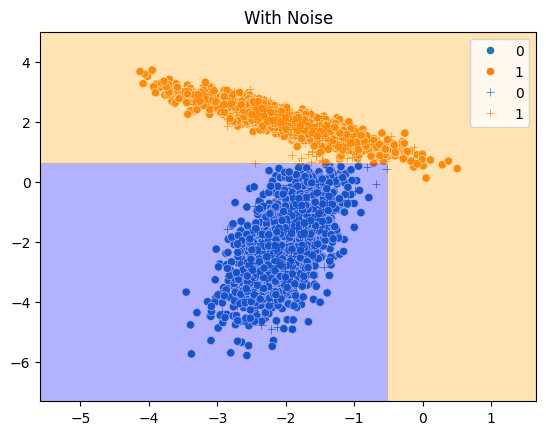

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


clf = DecisionTreeClassifier(max_depth=2)
clf2 = LogisticRegression()
abc = AdaBoostClassifier(estimator=clf, n_estimators=10, learning_rate=1)
flip_level = .2
Div_plate(abc, flip_level=flip_level)

### XGBoost

In [36]:
import xgboost


URL = 'https://drive.google.com/uc?id=1soReu6FBB_4LxvuNnV_ULUW-WGlNaZg2'
dataset = np.loadtxt(URL, delimiter=',')

X = dataset[:, 0:8]
y = dataset[:, 8]

seed = 7
test_size = .33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

model = xgboost.XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 72.44%


### Catboost

In [38]:
from catboost import Pool, CatBoostClassifier


train_data = [['summer', 1924, 44],
              ['summer', 1932, 37],
              ['winter', 1980, 37],
              ['summer', 2012, 204]]

eval_data = [['winter', 1996, 197],
             ['winter', 1968, 37],
             ['summer', 2002, 77],
             ['summer', 1948, 59]]

cat_features = [0]

train_label = ['France', 'USA', 'USA', 'UK']
eval_label = ['USA', 'France', 'USA', 'UK']

train_dataset = Pool(data=train_data,
                     label=train_label,
                     cat_features=cat_features)

eval_dataset = Pool(data=eval_data,
                    label=eval_label,
                    cat_features=cat_features)

model = CatBoostClassifier(iterations=10,
                        learning_rate=1,
                        depth=2,
                        loss_function='MultiClass')

model.fit(train_dataset)
preds_class = model.predict(eval_dataset)
preds_proba = model.predict_proba(eval_dataset)
preds_class

0:	learn: 0.9417331	total: 142ms	remaining: 1.28s
1:	learn: 0.8421839	total: 143ms	remaining: 571ms
2:	learn: 0.6597822	total: 143ms	remaining: 334ms
3:	learn: 0.6028493	total: 143ms	remaining: 215ms
4:	learn: 0.4900112	total: 143ms	remaining: 143ms
5:	learn: 0.4076408	total: 144ms	remaining: 95.7ms
6:	learn: 0.3458205	total: 144ms	remaining: 61.7ms
7:	learn: 0.2982687	total: 144ms	remaining: 36ms
8:	learn: 0.2608927	total: 144ms	remaining: 16ms
9:	learn: 0.2309514	total: 144ms	remaining: 0us


array([['USA'],
       ['USA'],
       ['UK'],
       ['USA']], dtype=object)

### Cross-validation

In [41]:
from catboost import cv


cv_data = [['France', 1924, 44],
           ['USA', 1932, 37],
           ['Switzerland', 1928, 25],
           ['Norway', 1952, 30],
           ['Japan', 1972, 35],
           ['Mexico', 1968, 112]]

labels = [1, 1, 0, 0, 0, 1]

cat_features = [0]

cv_dataset = Pool(data=cv_data,
                  label=labels,
                  cat_features=cat_features)

params = {
    'iterations': 100, 
    'depth': 2, 
    'loss_function': 'Logloss',
    'verbose': False
}

scores = cv(cv_dataset, 
            params,
            fold_count=3,
            plot=False)

Training on fold [0/3]

bestTest = 0.6806661468
bestIteration = 1

Training on fold [1/3]

bestTest = 0.7062352628
bestIteration = 0

Training on fold [2/3]

bestTest = 0.693188484
bestIteration = 0



In [42]:
scores

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.701886,0.007533,0.686716,7.850462e-17
1,1,0.693624,0.012898,0.661645,1.110223e-16
2,2,0.702647,0.006738,0.637718,0.000000e+00
3,3,0.716449,0.014089,0.625042,8.796724e-03
4,4,0.710532,0.006287,0.606618,8.448647e-03
...,...,...,...,...,...
95,95,1.102985,0.195439,0.099079,7.536046e-03
96,96,1.109511,0.194170,0.097707,7.360085e-03
97,97,1.115997,0.192900,0.096368,7.189676e-03
98,98,1.122444,0.191630,0.095060,7.024605e-03


In [43]:
from sklearn.datasets import fetch_california_housing
from catboost import CatBoostRegressor
import pandas as pd
from sklearn.inspection import permutation_importance


housing = fetch_california_housing()
X, y = housing.data, housing.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=5)
train_dataset = Pool(X_train, y_train)
test_dataset = Pool(X_test, y_test)

model = CatBoostRegressor(loss_function='RMSE')

grid = {
    'iterations': [100, 150, 200],
    'learning_rate': [.03, .1],
    'depth': [2, 4, 6, 8],
    'l2_leaf_reg': [.2, .5, 1, 3]
}

model.grid_search(grid, train_dataset)

0:	learn: 2.2989646	test: 2.3122953	best: 2.3122953 (0)	total: 2.43ms	remaining: 241ms
1:	learn: 2.2426201	test: 2.2559234	best: 2.2559234 (1)	total: 4.05ms	remaining: 198ms
2:	learn: 2.1860231	test: 2.1987884	best: 2.1987884 (2)	total: 5.57ms	remaining: 180ms
3:	learn: 2.1332428	test: 2.1458684	best: 2.1458684 (3)	total: 7.68ms	remaining: 184ms
4:	learn: 2.0815544	test: 2.0939945	best: 2.0939945 (4)	total: 9.12ms	remaining: 173ms
5:	learn: 2.0311377	test: 2.0428699	best: 2.0428699 (5)	total: 10.6ms	remaining: 166ms
6:	learn: 1.9823586	test: 1.9939379	best: 1.9939379 (6)	total: 12ms	remaining: 160ms
7:	learn: 1.9346464	test: 1.9458311	best: 1.9458311 (7)	total: 13.5ms	remaining: 155ms
8:	learn: 1.8897305	test: 1.9006096	best: 1.9006096 (8)	total: 15.1ms	remaining: 152ms
9:	learn: 1.8457034	test: 1.8562125	best: 1.8562125 (9)	total: 16.5ms	remaining: 149ms
10:	learn: 1.8032371	test: 1.8131590	best: 1.8131590 (10)	total: 18ms	remaining: 146ms
11:	learn: 1.7622477	test: 1.7717155	best: 1.

{'params': {'depth': 8,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.5,
  'iterations': 200},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [46]:
pred = model.predict(X_test)
rmse = (np.sqrt(metrics.mean_squared_error(y_test, pred)))
r2 = metrics.r2_score(y_test, pred)
print('Testing Perfomance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing Perfomance
RMSE: 0.46
R2: 0.85


<Axes: >

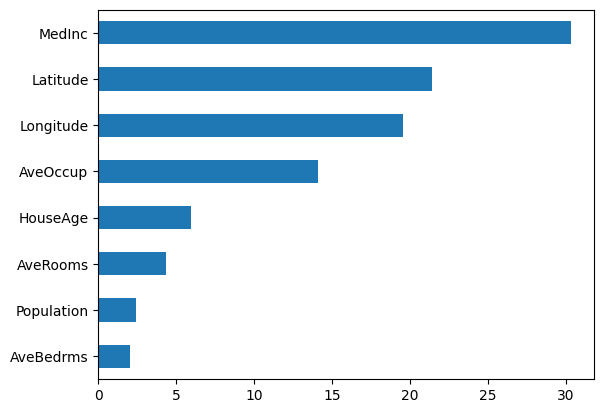

In [47]:
sorted_feature_importance = model.feature_importances_.argsort()
(pd.Series(model.feature_importances_, index=housing.feature_names).sort_values().plot(kind='barh'))